In [1]:
import sys
sys.path.append("/Users/suma/Documents/01 Data Science/02 Algorithmica/utils")

import os
import pandas as pd
import missingno as msno
#from sklearn import preprocessing, ensemble, model_selection, tree, neighbors
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import decimal
decimal.getcontext().prec = 10
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
df_building_metadata = pd.read_csv('Data/building_metadata.csv')

In [3]:
df_train = pd.read_csv('Data/train.csv')
df_train.timestamp = df_train.timestamp.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [4]:
df_train_building = pd.merge(df_train, df_building_metadata, on='building_id', how = 'left')
df_train_building['meter_reading_per_sqft_log1p'] = df_train_building[['meter_reading', 'square_feet']].apply(lambda x: np.log1p(x['meter_reading']/x['square_feet']), axis = 1)

In [5]:
#df_train_building['log_meter_reading'] = df_train_building.meter_reading.apply(lambda x: np.log1p(x))
#df_train_building['log_sqft'] = df_train_building.square_feet.apply(lambda x: np.log1p(x))
df_train_building['log_meter_reading_per_logsqft'] = df_train_building.meter_reading.apply(lambda x: np.log1p(x)) / df_train_building.square_feet.apply(lambda x: np.log1p(x))

In [6]:
df_train_building['day_hour'] = df_train_building.timestamp.apply(lambda x: str(x.timetuple().tm_yday).zfill(3) + '-' + str(x.hour).zfill(2))
df_train_building['day_of_the_year'] = df_train_building.timestamp.apply(lambda x: x.timetuple().tm_yday)
df_train_building['month_year']= df_train_building.timestamp.apply(lambda x: (str(x.month) + '-' + str(x.year)) if x.month > 9 else ('0' + str(x.month) + '-' + str(x.year)) )
df_train_building['hour_of_the_day']= df_train_building.timestamp.dt.hour

In [7]:
df_train_building.day_of_the_year = df_train_building.day_of_the_year.astype(int)
df_train_building.hour_of_the_day = df_train_building.hour_of_the_day.astype(int)

##### Weather Data

In [8]:
df_weather_train = pd.read_csv('Data/weather_train.csv')
df_weather_train.timestamp = df_weather_train.timestamp.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [2]:
df_weather_test = pd.read_csv('Data/weather_test.csv')
df_weather_test.timestamp = df_weather_test.timestamp.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [23]:
df_data = pd.merge(df_train_building, df_weather_train, on=['site_id', 'timestamp'], how = 'left')

In [12]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 22 columns):
building_id                      int64
meter                            int64
timestamp                        datetime64[ns]
meter_reading                    float64
site_id                          int64
primary_use                      object
square_feet                      int64
year_built                       float64
floor_count                      float64
meter_reading_per_sqft_log1p     float64
log_meter_reading_per_logsqft    float64
day_of_the_year                  int64
day_hour                         object
month_year                       object
hour_of_the_day                  int64
air_temperature                  float64
cloud_coverage                   float64
dew_temperature                  float64
precip_depth_1_hr                float64
sea_level_pressure               float64
wind_direction                   float64
wind_speed                      

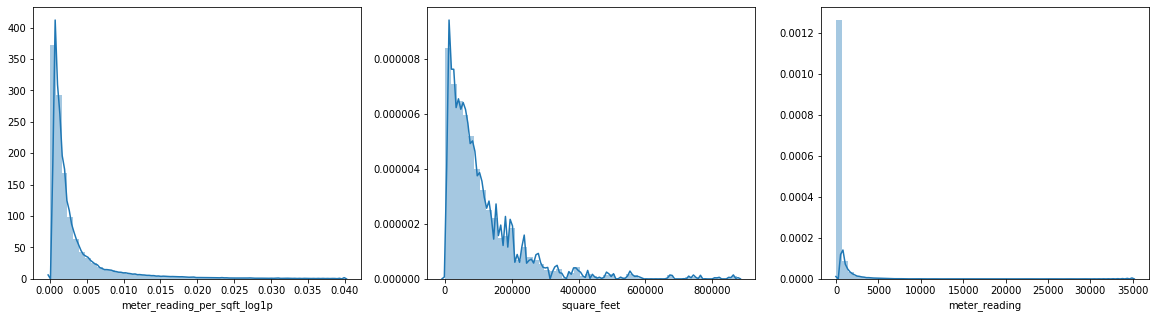

In [24]:
import numpy as np
f, ax = plt.subplots(1, 3, figsize=(20,5))
data = df_data[(df_data.meter_reading_per_sqft_log1p< 0.04) & (df_data.meter_reading != 0)]
sns.distplot(data['meter_reading_per_sqft_log1p'], ax = f.axes[0]);
sns.distplot(data['square_feet'], ax = f.axes[1]);
sns.distplot(data['meter_reading'], ax = f.axes[2]);

In [98]:
print(df_data.shape)
df_data = df_data[df_data.building_id != 1099]
print(df_data.shape)

(20216100, 20)
(20198534, 20)


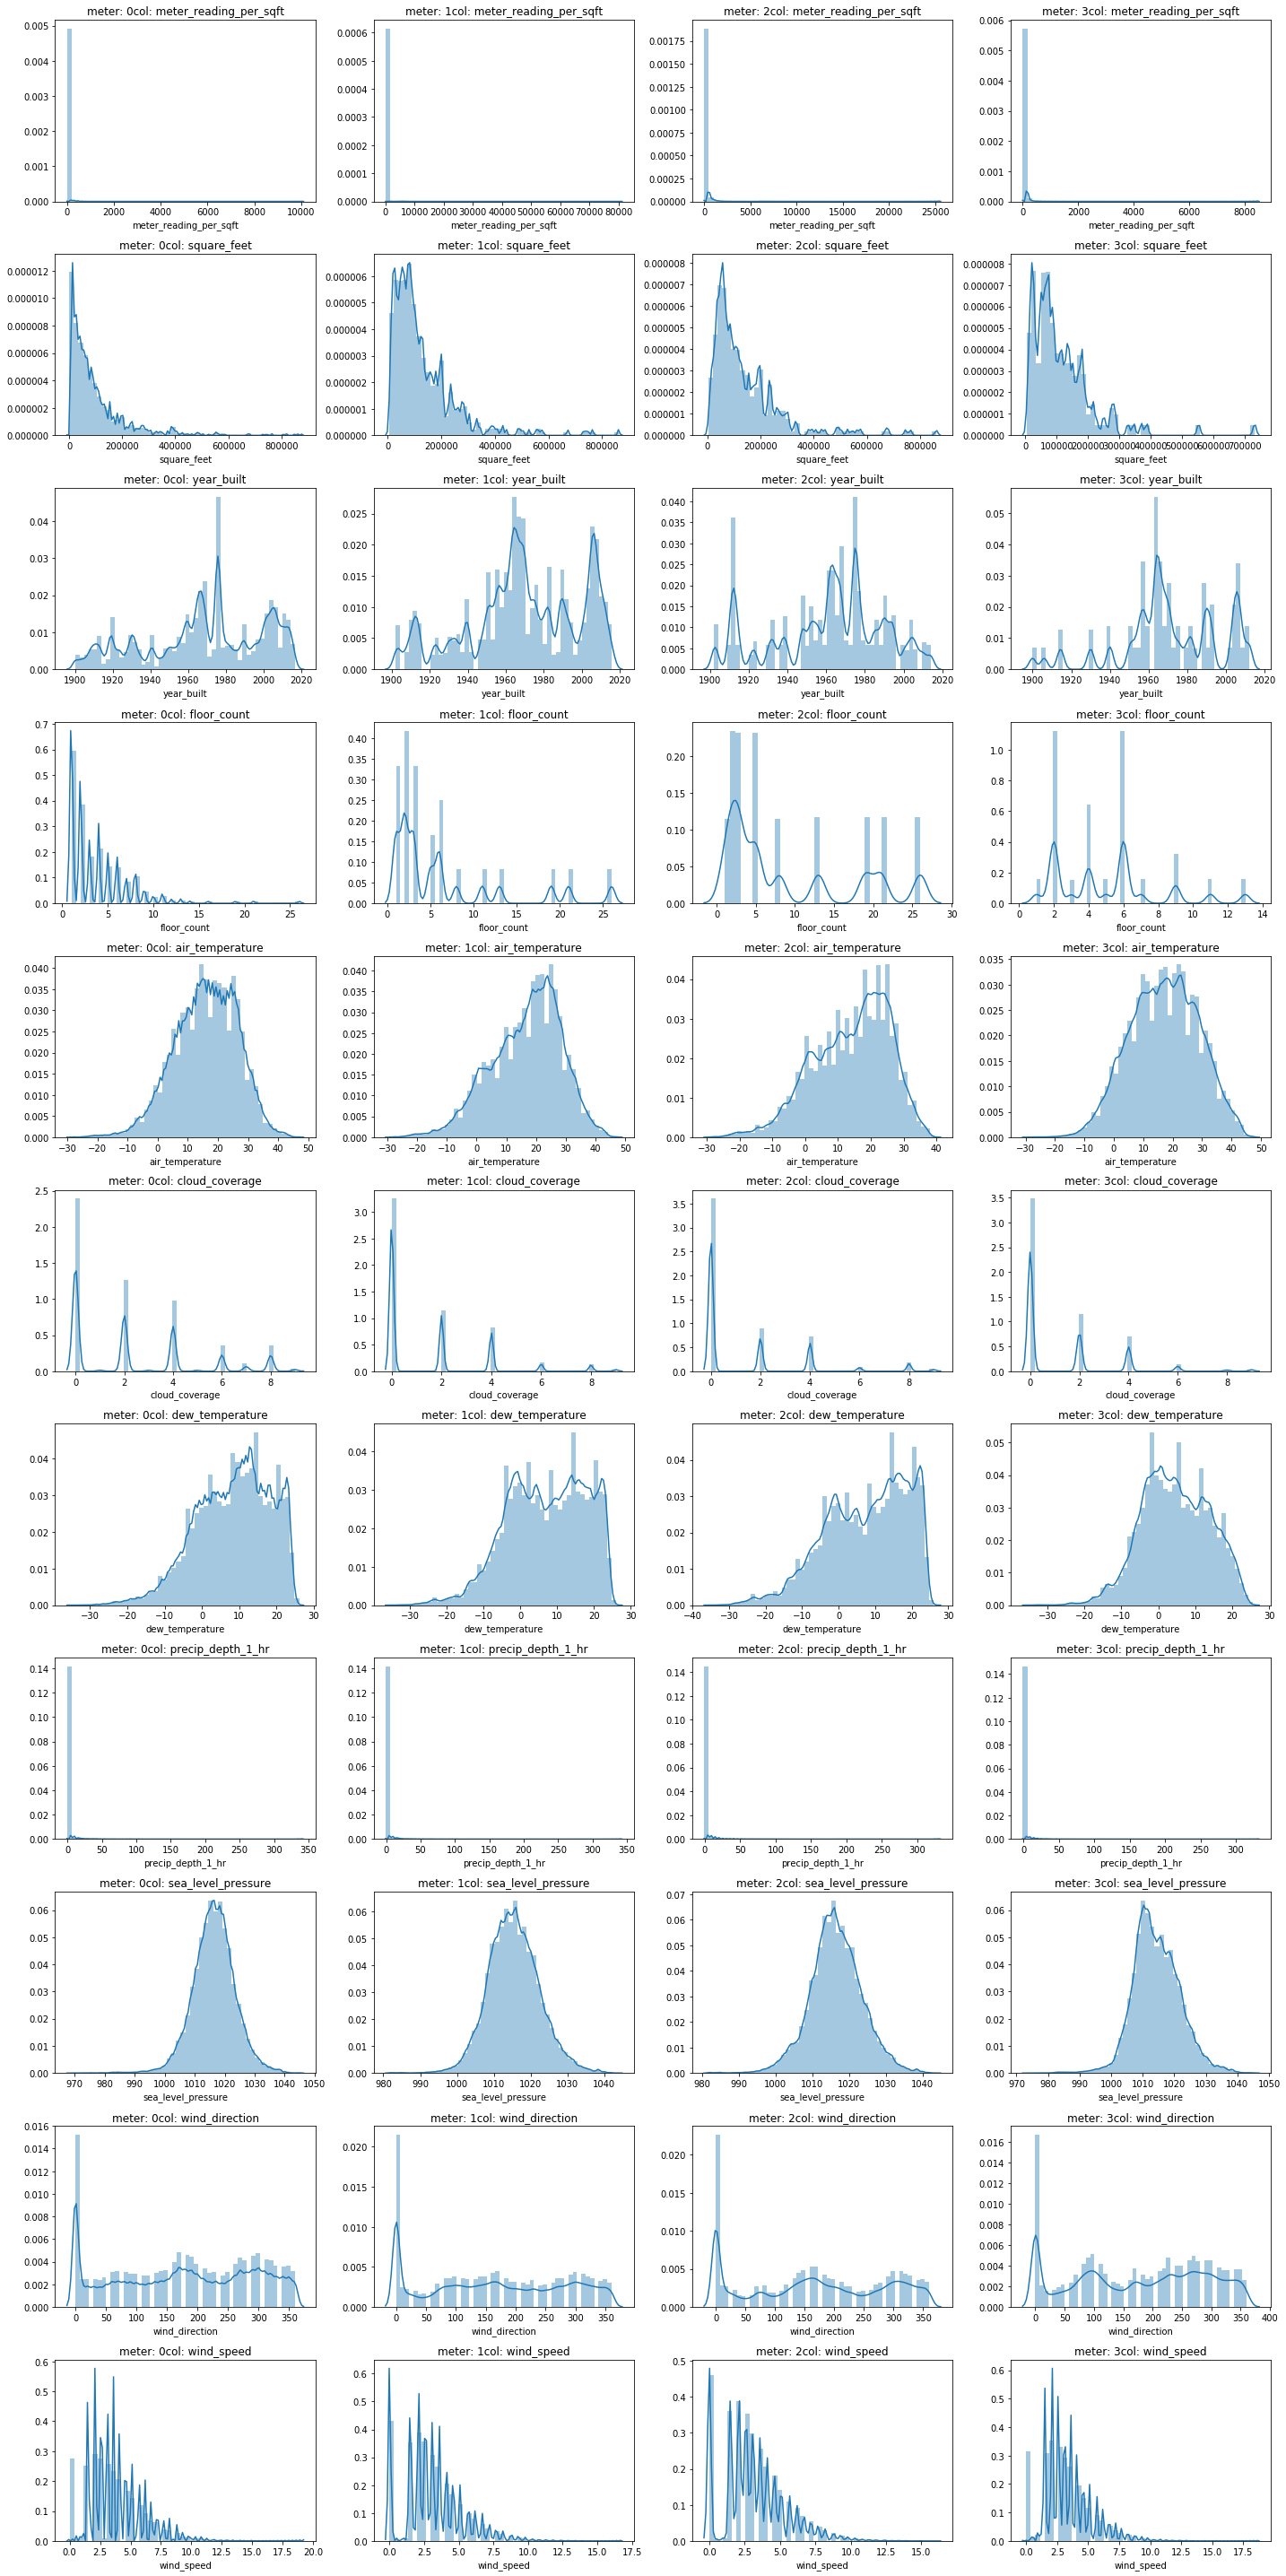

In [99]:
distplot_cols = ['meter_reading_per_sqft', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']

f, ax = plt.subplots(11, 4, figsize=(20,40))

i = 0
for col in distplot_cols:
    for meter in [0,1, 2, 3]:
        ax = f.axes[i]
        data = df_data[(df_data[col].isnull() == False) & (df_data.meter == meter)]
        if data.shape[0] !=0:
            sns.distplot(data[col], ax = ax)
            ax.set(title = 'meter: '+ str(meter) + ' col: '+ str(col))
        i = i + 1
plt.tight_layout()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df_data.air_temperature, df_data.sea_pressure, df_data.meter_reading_per_sqft_log1p)
plt.show()

In [ ]:
##### For each site id, what is the air temperature at a given hour of the day
f, ax = plt.subplots(8, 2, figsize=(20,40))

i = 0
for site_id in df_weather_train.site_id.unique():
    ax = f.axes[i]
    data = df_weather_train[df_weather_train.site_id == site_id]
    if data.shape[0] !=0:
        sns.boxplot(x='hour_of_the_day', y = 'air_temperature', data = data, ax = ax)
        ax.set(title = 'site id: '+ str(site_id), ylim = (-30, 40))
    i = i + 1

In [ ]:
##### For each month, what is the air temperature at a given hour of the day
f, ax = plt.subplots(6, 2, figsize=(20,30))

i = 0
site_id = 3
for month_year in df_weather_train.month_year.unique():
    ax = f.axes[i]
    data = df_weather_train[(df_weather_train.month_year == month_year) & (df_weather_train.site_id == site_id)]
    if data.shape[0] !=0:
        sns.boxplot(x='hour_of_the_day', y = 'air_temperature', data = data, ax = ax)
        ax.set(title = 'month: '+ month_year, ylim = (-20, 35))
    i = i + 1
plt.tight_layout()

In [12]:
from scipy.stats import pearsonr
corr, _ = pearsonr(df_data[df_data.sea_level_pressure.isnull() == False]['air_temperature'], df_data[df_data.sea_level_pressure.isnull() == False]['sea_level_pressure'])
print(corr, _)

-0.3157727533351537 0.0


In [ ]:
print(corr)

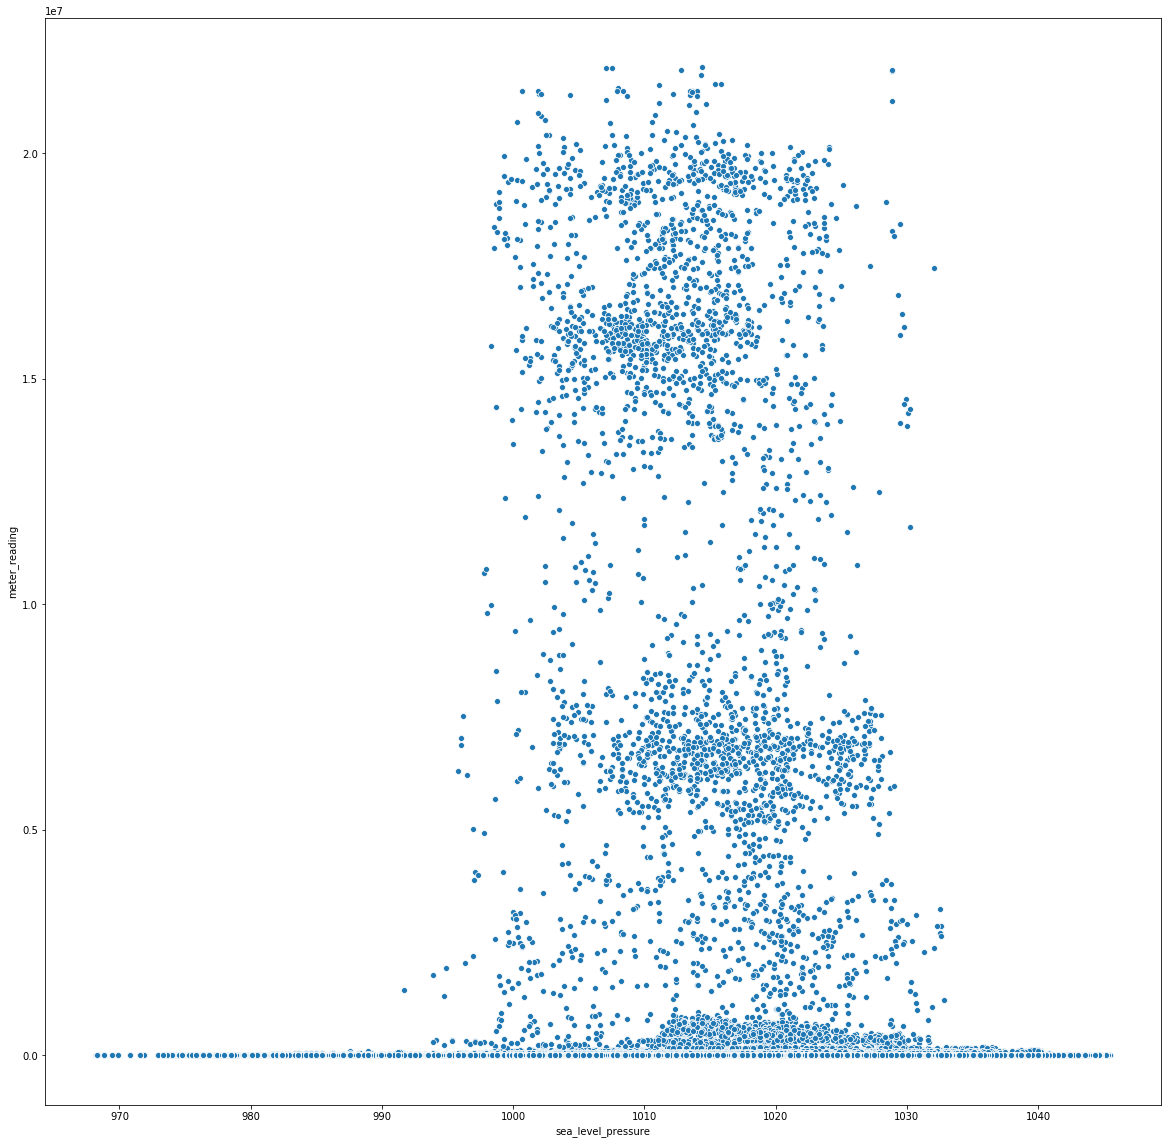

In [22]:
fig, ax = plt.subplots(1,1, figsize = (20,20))
sns.scatterplot(x ='sea_level_pressure', y = 'meter_reading_per_sqft_log1p', data = df_data, ax = ax)

In [16]:
df_data.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count',
       'meter_reading_per_sqft_log1p', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'day_of_the_year', 'month_year',
       'hour_of_the_day'],
      dtype='object')

In [19]:
df_data.sea_level_pressure.describe()

count   18984431.00000
mean        1016.08549
std            7.06054
min          968.20000
25%         1011.60000
50%         1016.00000
75%         1020.50000
max         1045.50000
Name: sea_level_pressure, dtype: float64

In [26]:
df_data.describe()

building_id          meter  meter_reading        site_id  \
count 20216100.00000 20216100.00000 20216100.00000 20216100.00000   
mean       799.27800        0.66244     2117.12108        7.99223   
std        426.91331        0.93099   153235.62499        5.09906   
min          0.00000        0.00000        0.00000        0.00000   
25%        393.00000        0.00000       18.30000        3.00000   
50%        895.00000        0.00000       78.77500        9.00000   
75%       1179.00000        1.00000      267.98400       13.00000   
max       1448.00000        3.00000 21904700.00000       15.00000   

         square_feet    year_built   floor_count  \
count 20216100.00000 8088455.00000 3506933.00000   
mean    107782.98133    1968.27674       4.18485   
std     117142.44365      30.20815       4.00828   
min        283.00000    1900.00000       1.00000   
25%      32527.00000    1951.00000       1.00000   
50%      72709.00000    1969.00000       3.00000   
75%     139113.00000    1993.00000       6.00000   
max     875000.00000    2017.00000      26.00000   

       meter_reading_per_sqft_log1p  air_temperature  cloud_coverage  \
count                20216100.00000   20119442.00000  11390735.00000   
mean                        0.00466         15.98795         1.90042   
std                         0.04705         10.94729         2.40291   
min                         0.00000        -28.90000         0.00000   
25%                         0.00049          8.60000         0.00000   
50%                         0.00129         16.70000         0.00000   
75%                         0.00308         24.10000         4.00000   
max                         4.20175         47.20000         9.00000   

       dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
count   20115960.00000     16467077.00000      18984431.00000  18767052.00000   
mean           7.74743            0.79642          1016.08549       173.01510   
std           10.17867            7.46900             7.06054       114.05736   
min          -35.00000           -1.00000           968.20000         0.00000   
25%            0.00000            0.00000          1011.60000        70.00000   
50%            8.90000            0.00000          1016.00000       180.00000   
75%           16.10000            0.00000          1020.50000       280.00000   
max           26.10000          343.00000          1045.50000       360.00000   

          wind_speed  day_of_the_year  hour_of_the_day  
count 20072424.00000   20125605.00000   20125605.00000  
mean         3.37752        185.65484         11.51151  
std          2.26569        105.22071          6.92381  
min          0.00000          1.00000          0.00000  
25%          2.10000         97.00000          6.00000  
50%          3.10000        186.00000         12.00000  
75%          4.60000        277.00000         18.00000  
max         19.00000        366.00000         23.00000

In [28]:
df_month_summary = pd.DataFrame()
df_month_summary = pd.crosstab([df_data.site_id, df_data.primary_use, df_data.building_id, df_data.meter], df_data.month_year, df_data.meter_reading, aggfunc=sum, margins = True )#, normalize = 'columns')

In [29]:
df_month_summary.to_excel('month_summary.xlsx')

In [108]:
df_data.head()

building_id  meter  timestamp  meter_reading  site_id primary_use  \
0            0      0 2016-01-01        0.00000        0   Education   
1            1      0 2016-01-01        0.00000        0   Education   
2            2      0 2016-01-01        0.00000        0   Education   
3            3      0 2016-01-01        0.00000        0   Education   
4            4      0 2016-01-01        0.00000        0   Education   

   square_feet  year_built  floor_count  meter_reading_per_sqft_log1p  \
0         7432  2008.00000          nan                       0.00000   
1         2720  2004.00000          nan                       0.00000   
2         5376  1991.00000          nan                       0.00000   
3        23685  2002.00000          nan                       0.00000   
4       116607  1975.00000          nan                       0.00000   

   air_temperature  cloud_coverage  dew_temperature  precip_depth_1_hr  \
0         25.00000         6.00000         20.00000                nan   
1         25.00000         6.00000         20.00000                nan   
2         25.00000         6.00000         20.00000                nan   
3         25.00000         6.00000         20.00000                nan   
4         25.00000         6.00000         20.00000                nan   

   sea_level_pressure  wind_direction  wind_speed  day_of_the_year month_year  \
0          1019.70000         0.00000     0.00000          1.00000    01-2016   
1          1019.70000         0.00000     0.00000          1.00000    01-2016   
2          1019.70000         0.00000     0.00000          1.00000    01-2016   
3          1019.70000         0.00000     0.00000          1.00000    01-2016   
4          1019.70000         0.00000     0.00000          1.00000    01-2016   

   hour_of_the_day  log_meter_reading  log_sqft  \
0          0.00000            0.00000   8.91368   
1          0.00000            0.00000   7.90875   
2          0.00000            0.00000   8.58989   
3          0.00000            0.00000  10.07264   
4          0.00000            0.00000  11.66657   

   log_meter_reading_per_logsqft  root_meter_reading  
0                        0.00000             0.00000  
1                        0.00000             0.00000  
2                        0.00000             0.00000  
3                        0.00000             0.00000  
4                        0.00000             0.00000

In [30]:
df_data['log_meter_reading'] = df_data.meter_reading.apply(lambda x: np.log1p(x))
df_data['log_sqft'] = df_data.square_feet.apply(lambda x: np.log1p(x))

In [96]:
data = df_data[(df_data.primary_use == primary_use) & (df_data.meter == meter)]

In [101]:
len(df_data.primary_use.unique())

16

In [106]:
df_data['root_meter_reading'] = df_data.meter_reading.apply(lambda x: np.sqrt(x))

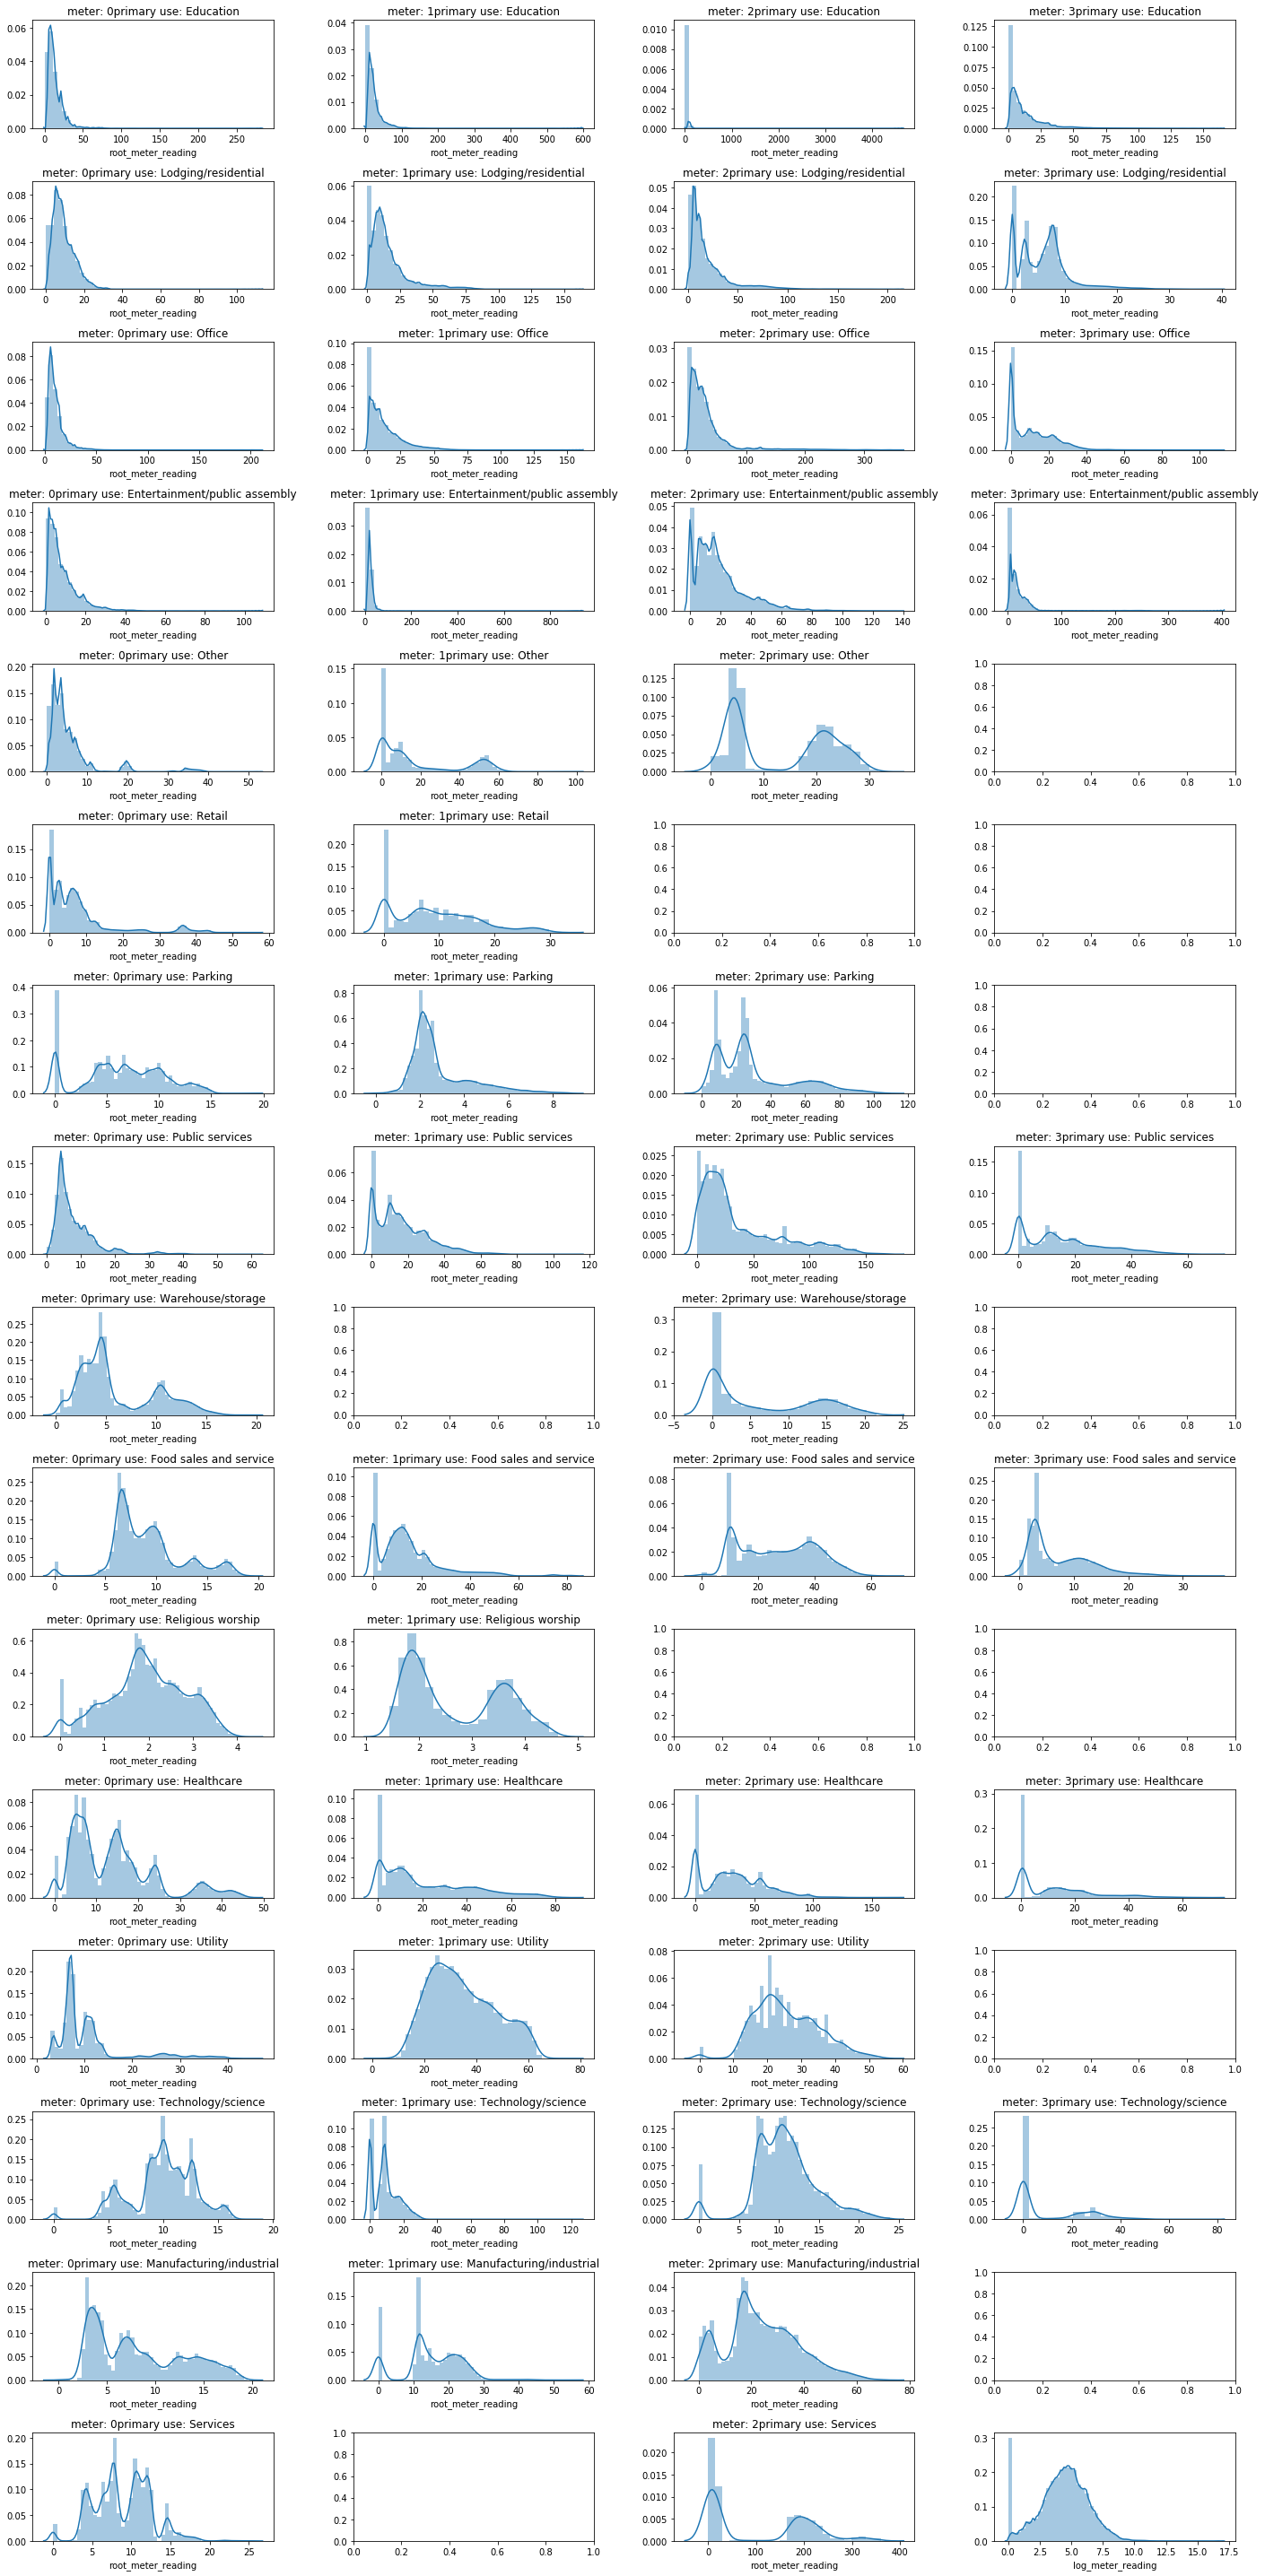

In [107]:
distplot_cols = ['meter_reading_per_sqft', 'square_feet', 'year_built', 'floor_count', 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']

f, ax = plt.subplots(16, 4, figsize=(20,40))

i = 0
data = pd.DataFrame()
for primary_use in df_data.primary_use.unique():
    for meter in [0,1, 2, 3]:
        ax = f.axes[i]
        data = df_data[(df_data.primary_use == primary_use) & (df_data.meter == meter)]
        if data.shape[0] !=0:
            sns.distplot(data.root_meter_reading, ax = ax)
            ax.set(title = 'meter: '+  str(meter) + "primary use: "+ primary_use)
        i = i + 1
plt.tight_layout()


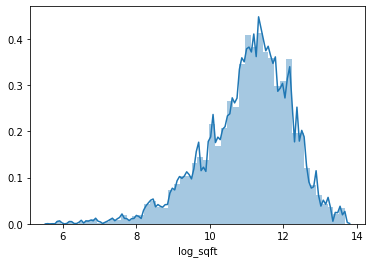

In [32]:
sns.distplot(df_data.log_sqft)

In [33]:
df_data['log_meter_reading'] = df_data.meter_reading.apply(lambda x: np.log1p(x))
df_data['log_sqft'] = df_data.square_feet.apply(lambda x: np.log1p(x))
df_data['log_meter_reading_per_logsqft'] = df_data.log_meter_reading/df_data.log_sqft

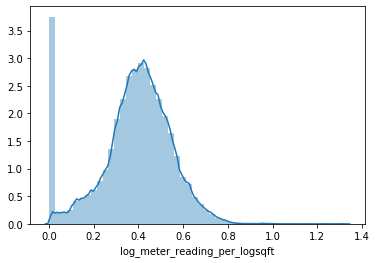

In [34]:
sns.distplot(df_data.log_meter_reading_per_logsqft)

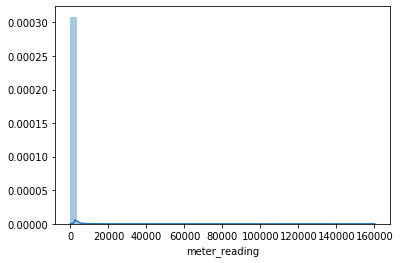

In [46]:
sns.distplot(df_data[df_data.meter ==3]['meter_reading'])

In [65]:
df_data[(df_data.meter == 1) & (df_data.building_id == 43)].to_excel('b_id: 43 chilled water.xlsx')

In [62]:
df_temp = pd.DataFrame()
df_temp['zero_count'] = df_data[(df_data.meter == 1) & (df_data.meter_reading == 0)].groupby(['building_id'])['meter_reading'].count()
df_temp['total_count'] = df_data[(df_data.meter == 1)].groupby(['building_id'])['meter_reading'].count()

In [63]:
df_temp.to_excel('zero_meter_reading_per_bid_in_chilledwater.xlsx')

In [67]:
df_data[df_data.building_id == 53].to_excel('builiding_id 53.xlsx')

In [82]:
temp = pd.DataFrame()
temp['non_zero_count'] = df_data[df_data.meter_reading != 0].groupby(['site_id', 'primary_use', 'building_id', 'meter'])['building_id'].count()
temp['zero_count'] = df_data[df_data.meter_reading == 0].groupby(['site_id', 'primary_use', 'building_id', 'meter'])['building_id'].count()
temp.zero_count.fillna(0)
temp['total']= temp.zero_count + temp.non_zero_count
temp.to_excel('zero_row_count.xlsx')

In [86]:
df_data.shape

(20216100, 23)

In [81]:
df_data[(df_data.meter_reading != 0) & (df_data.meter == 0) & (df_data.building_id == 106) & (df_data.site_id == 1) ].shape

(8780, 23)

In [85]:
temp.zero_count.fillna(0, inplace = True)
temp['total']= temp.zero_count + temp.non_zero_count
temp.to_excel('zero_row_count.xlsx')

In [87]:
df_data[df_data.primary_use == 'Education'].shape

(8165504, 23)

In [1]:
df_data[(df_data.building_id == 53) & (df_data.meter == 0)].to_excel('b_id 53 meter 0.xlsx')

NameError: name 'df_data' is not defined

In [92]:
df_data[df_data.day_of_the_year == 151]

building_id  meter           timestamp  meter_reading  site_id  \
8096236            0      0 2016-05-30 00:00:00      175.41800        0   
8096237            1      0 2016-05-30 00:00:00      137.87700        0   
8096238            2      0 2016-05-30 00:00:00        4.09540        0   
8096239            3      0 2016-05-30 00:00:00      384.96400        0   
8096240            4      0 2016-05-30 00:00:00     1497.54000        0   
...              ...    ...                 ...            ...      ...   
8152593         1444      0 2016-05-30 23:00:00        5.95000       15   
8152594         1445      0 2016-05-30 23:00:00        2.95000       15   
8152595         1446      0 2016-05-30 23:00:00        0.00000       15   
8152596         1447      0 2016-05-30 23:00:00      174.25000       15   
8152597         1448      0 2016-05-30 23:00:00        2.30000       15   

                           primary_use  square_feet  year_built  floor_count  \
8096236                      Education         7432  2008.00000          nan   
8096237                      Education         2720  2004.00000          nan   
8096238                      Education         5376  1991.00000          nan   
8096239                      Education        23685  2002.00000          nan   
8096240                      Education       116607  1975.00000          nan   
...                                ...          ...         ...          ...   
8152593  Entertainment/public assembly        19619  1914.00000          nan   
8152594                      Education         4298         nan          nan   
8152595  Entertainment/public assembly        11265  1997.00000          nan   
8152596            Lodging/residential        29775  2001.00000          nan   
8152597                         Office        92271  2001.00000          nan   

         meter_reading_per_sqft_log1p  air_temperature  cloud_coverage  \
8096236                       0.02333         25.60000         6.00000   
8096237                       0.04945         25.60000         6.00000   
8096238                       0.00076         25.60000         6.00000   
8096239                       0.01612         25.60000         6.00000   
8096240                       0.01276         25.60000         6.00000   
...                               ...              ...             ...   
8152593                       0.00030         26.10000         2.00000   
8152594                       0.00069         26.10000         2.00000   
8152595                       0.00000         26.10000         2.00000   
8152596                       0.00584         26.10000         2.00000   
8152597                       0.00002         26.10000         2.00000   

         dew_temperature  precip_depth_1_hr  sea_level_pressure  \
8096236         20.00000           -1.00000          1016.80000   
8096237         20.00000           -1.00000          1016.80000   
8096238         20.00000           -1.00000          1016.80000   
8096239         20.00000           -1.00000          1016.80000   
8096240         20.00000           -1.00000          1016.80000   
...                  ...                ...                 ...   
8152593         13.30000                nan          1012.90000   
8152594         13.30000                nan          1012.90000   
8152595         13.30000                nan          1012.90000   
8152596         13.30000                nan          1012.90000   
8152597         13.30000                nan          1012.90000   

         wind_direction  wind_speed  day_of_the_year month_year  \
8096236        30.00000     4.10000        151.00000    05-2016   
8096237        30.00000     4.10000        151.00000    05-2016   
8096238        30.00000     4.10000        151.00000    05-2016   
8096239        30.00000     4.10000        151.00000    05-2016   
8096240        30.00000     4.10000        151.00000    05-2016   
...                 ...         ...              ..

##### Missing Value Analysis

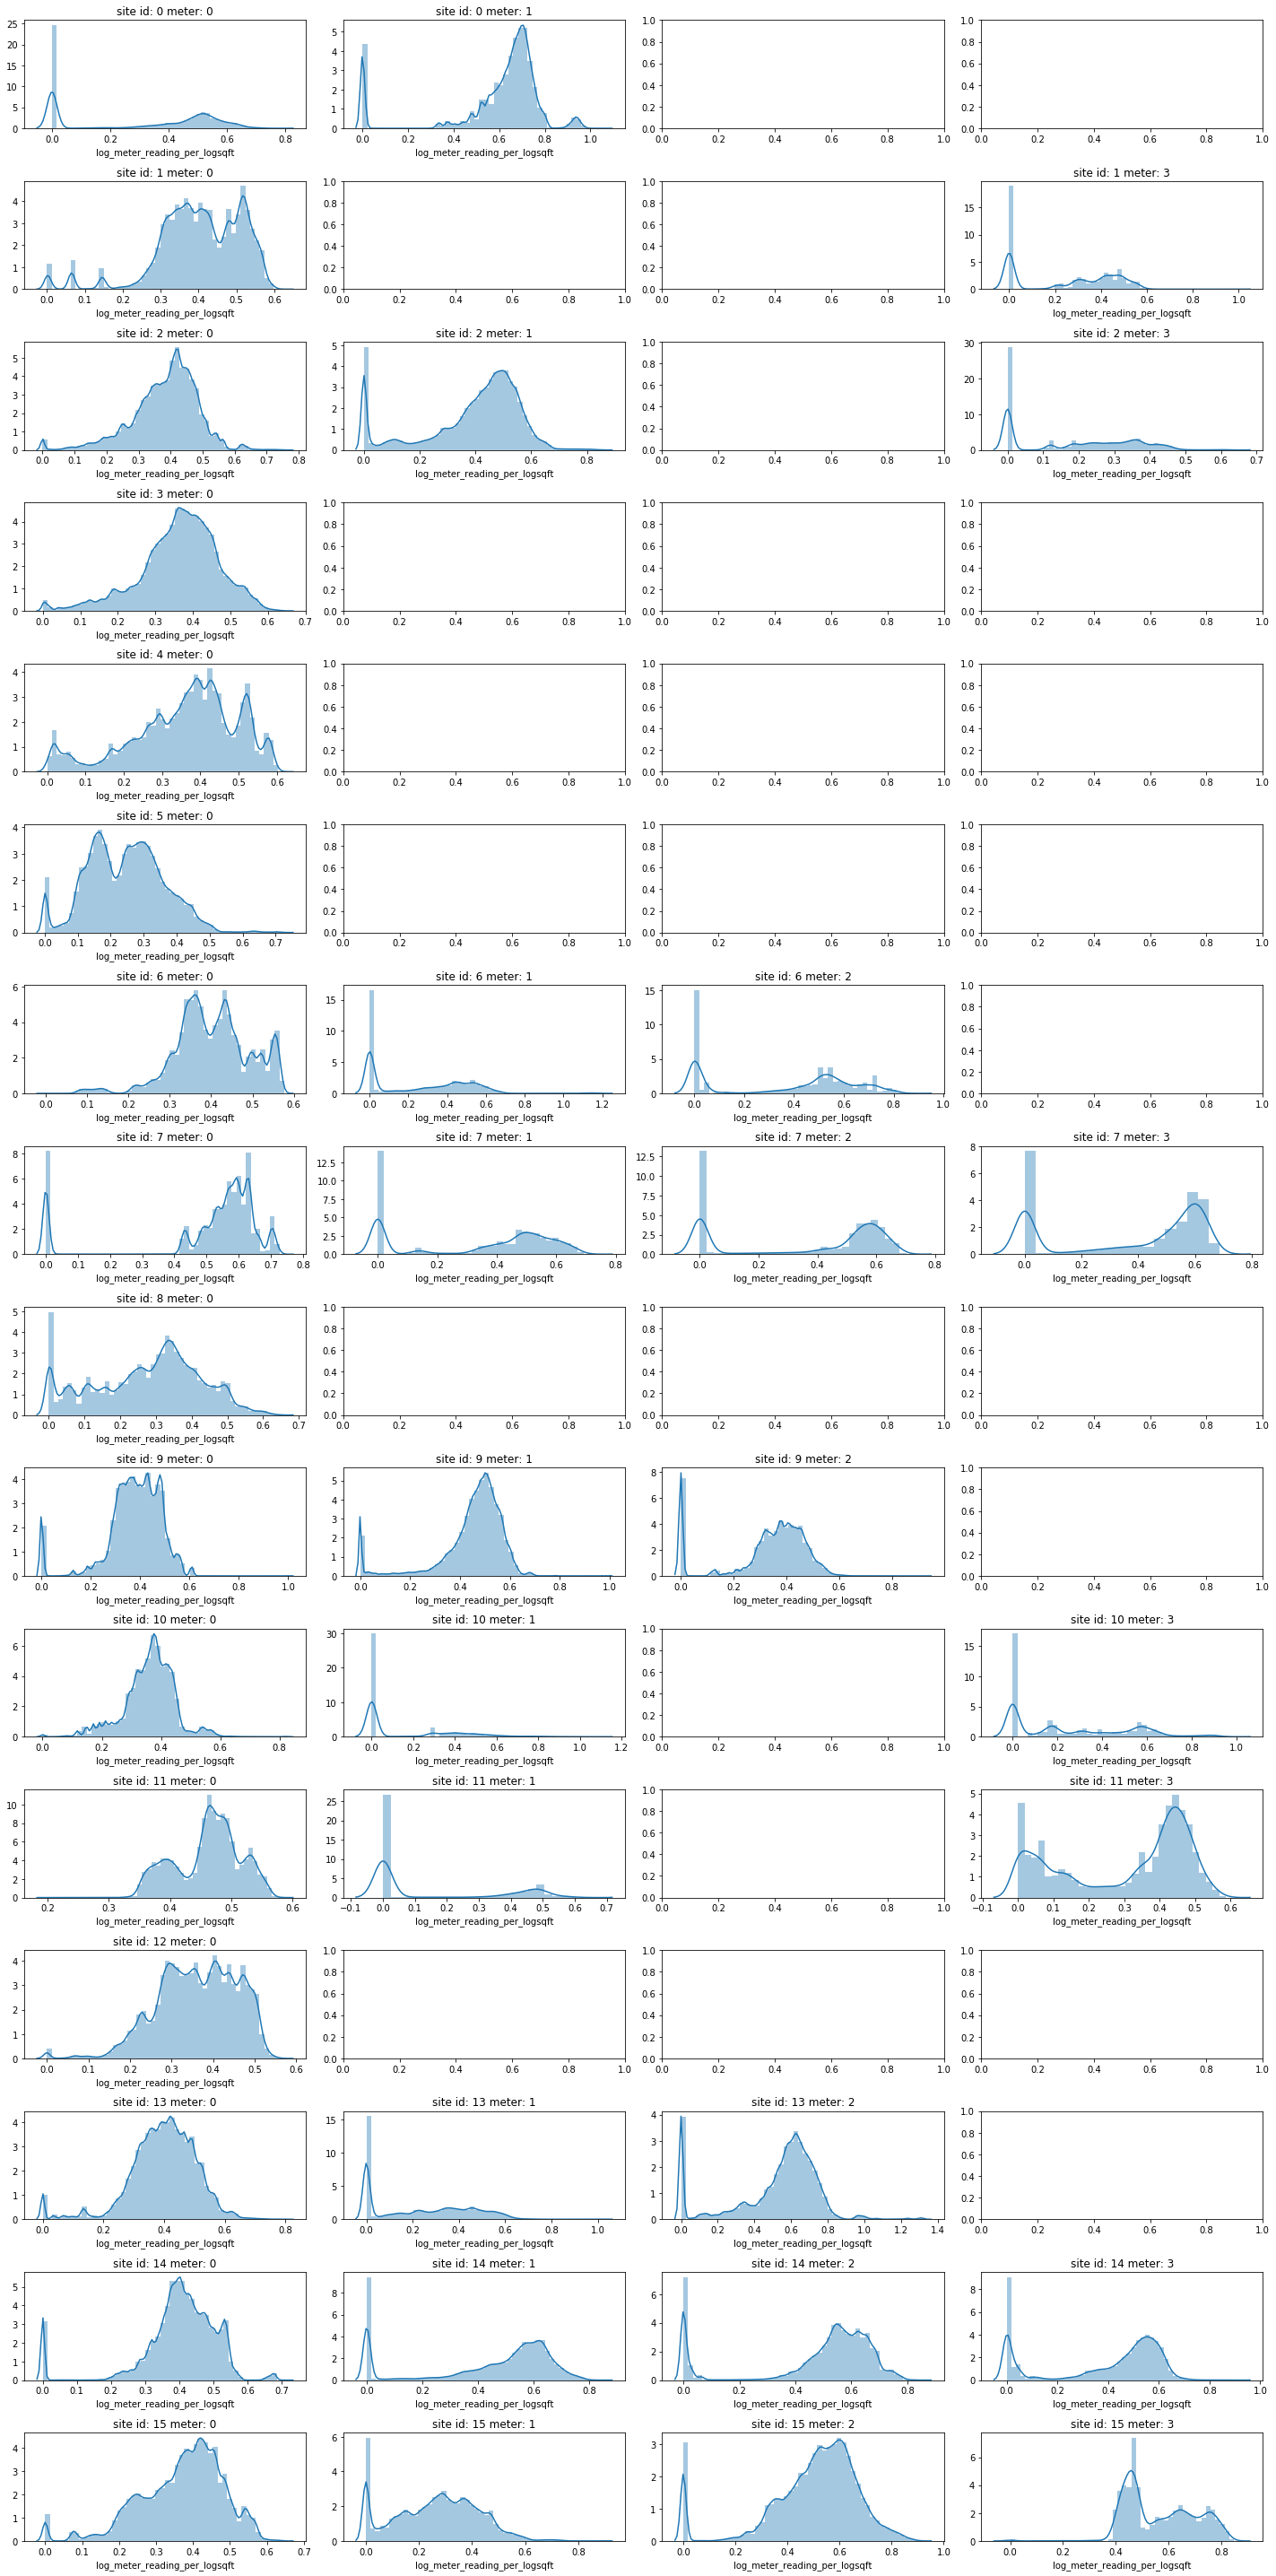

In [10]:
f, ax = plt.subplots(16, 4, figsize=(20,40))

i = 0
for site_id in list(range(0,16)):
    for meter in [0,1, 2, 3]:
        ax = f.axes[i]
        data = df_data[(df_data['site_id']==site_id) & (df_data.meter == meter)]
        if data.shape[0] !=0:
            sns.distplot(data['log_meter_reading_per_logsqft'], ax = ax)
            ax.set(title = 'site id: '+ str(site_id) + ' meter: '+ str(meter))
        i = i + 1
plt.tight_layout()

##### Missing Values after exclusions

In [79]:
#site id 0 meter 0
df_data = df_data[~((df_data.site_id ==0) & (df_data.meter ==0) & (df_data.month_year.isin(['01-2016', '02-2016', '03-2016','04-2016','05-2016'])))]
df_data = df_data[~((df_data.building_id == 29) & (df_data.meter == 0) & (df_data['timestamp'] < '2016-08-10'))]
df_data = df_data[~((df_data.building_id == 45) & (df_data.meter == 0) & (df_data['timestamp'] < '2016-07-01'))]
#site id 0 meter 1
df_data = df_data[~((df_data.site_id ==0) & (df_data.meter ==1) & (df_data.month_year.isin(['01-2016', '02-2016'])))]
df_data = df_data[~((df_data.building_id == 43) & (df_data.meter == 1) & (df_data['timestamp'] >= '2016-04-04') & (df_data['timestamp'] <= '2016-06-04'))]
df_data = df_data[~((df_data.building_id == 98) & (df_data.meter == 1) & (df_data['timestamp'] <= '2016-06-15'))]

#site id 1 meter 0
df_data = df_data[~((df_data.building_id == 106) & (df_data.meter == 0) & (df_data['timestamp'] < '2016-11-01'))]
df_data = df_data[~((df_data.building_id == 107) & (df_data.meter == 0) & (df_data['timestamp'] >= '2016-11-10'))]
df_data = df_data[~((df_data.building_id == 112) & (df_data.meter == 0) & (df_data['timestamp'] >= '2016-05-13') & (df_data['timestamp'] < '2016-11-01'))]
df_data = df_data[~((df_data.building_id == 144) & (df_data.meter == 0) & (df_data['timestamp'] >= '2016-03-08') & (df_data['timestamp'] < '2016-10-12'))]


In [190]:
#site id 0 meter 0
df_data = df_data[~((df_data.site_id ==0) & (df_data.meter ==0) & (df_data.month_year.isin(['01-2016', '02-2016', '03-2016','04-2016','05-2016'])))]
df_data = df_data[~((df_data.building_id.isin([29, 44, 45, 46, 53, 59, 83])) & (df_data.meter == 0) )]

#site id 0 meter 1
df_data = df_data[~((df_data.site_id ==0) & (df_data.meter ==1) & (df_data.month_year.isin(['01-2016', '02-2016'])))]
df_data = df_data[~((df_data.building_id.isin([7, 9, 28, 29, 43, 50, 60, 75, 98]) )& (df_data.meter == 1) )]

#site id 1 meter 0
df_data = df_data[~((df_data.building_id.isin([106, 107, 112, 124, 144, 146, 147])) & (df_data.meter == 0) )]

#site id 2 meter 0
df_data = df_data[~((df_data.building_id.isin([171, 177, 180, 186, 218, 230, 231, 252, 258, 260, 269, 272])) & (df_data.meter == 0) )]

In [200]:
df_data = df_data[~((df_data.building_id.isin([171, 177, 180, 186, 218, 230, 231, 252, 258, 260, 269, 272])) & (df_data.meter == 0) )]

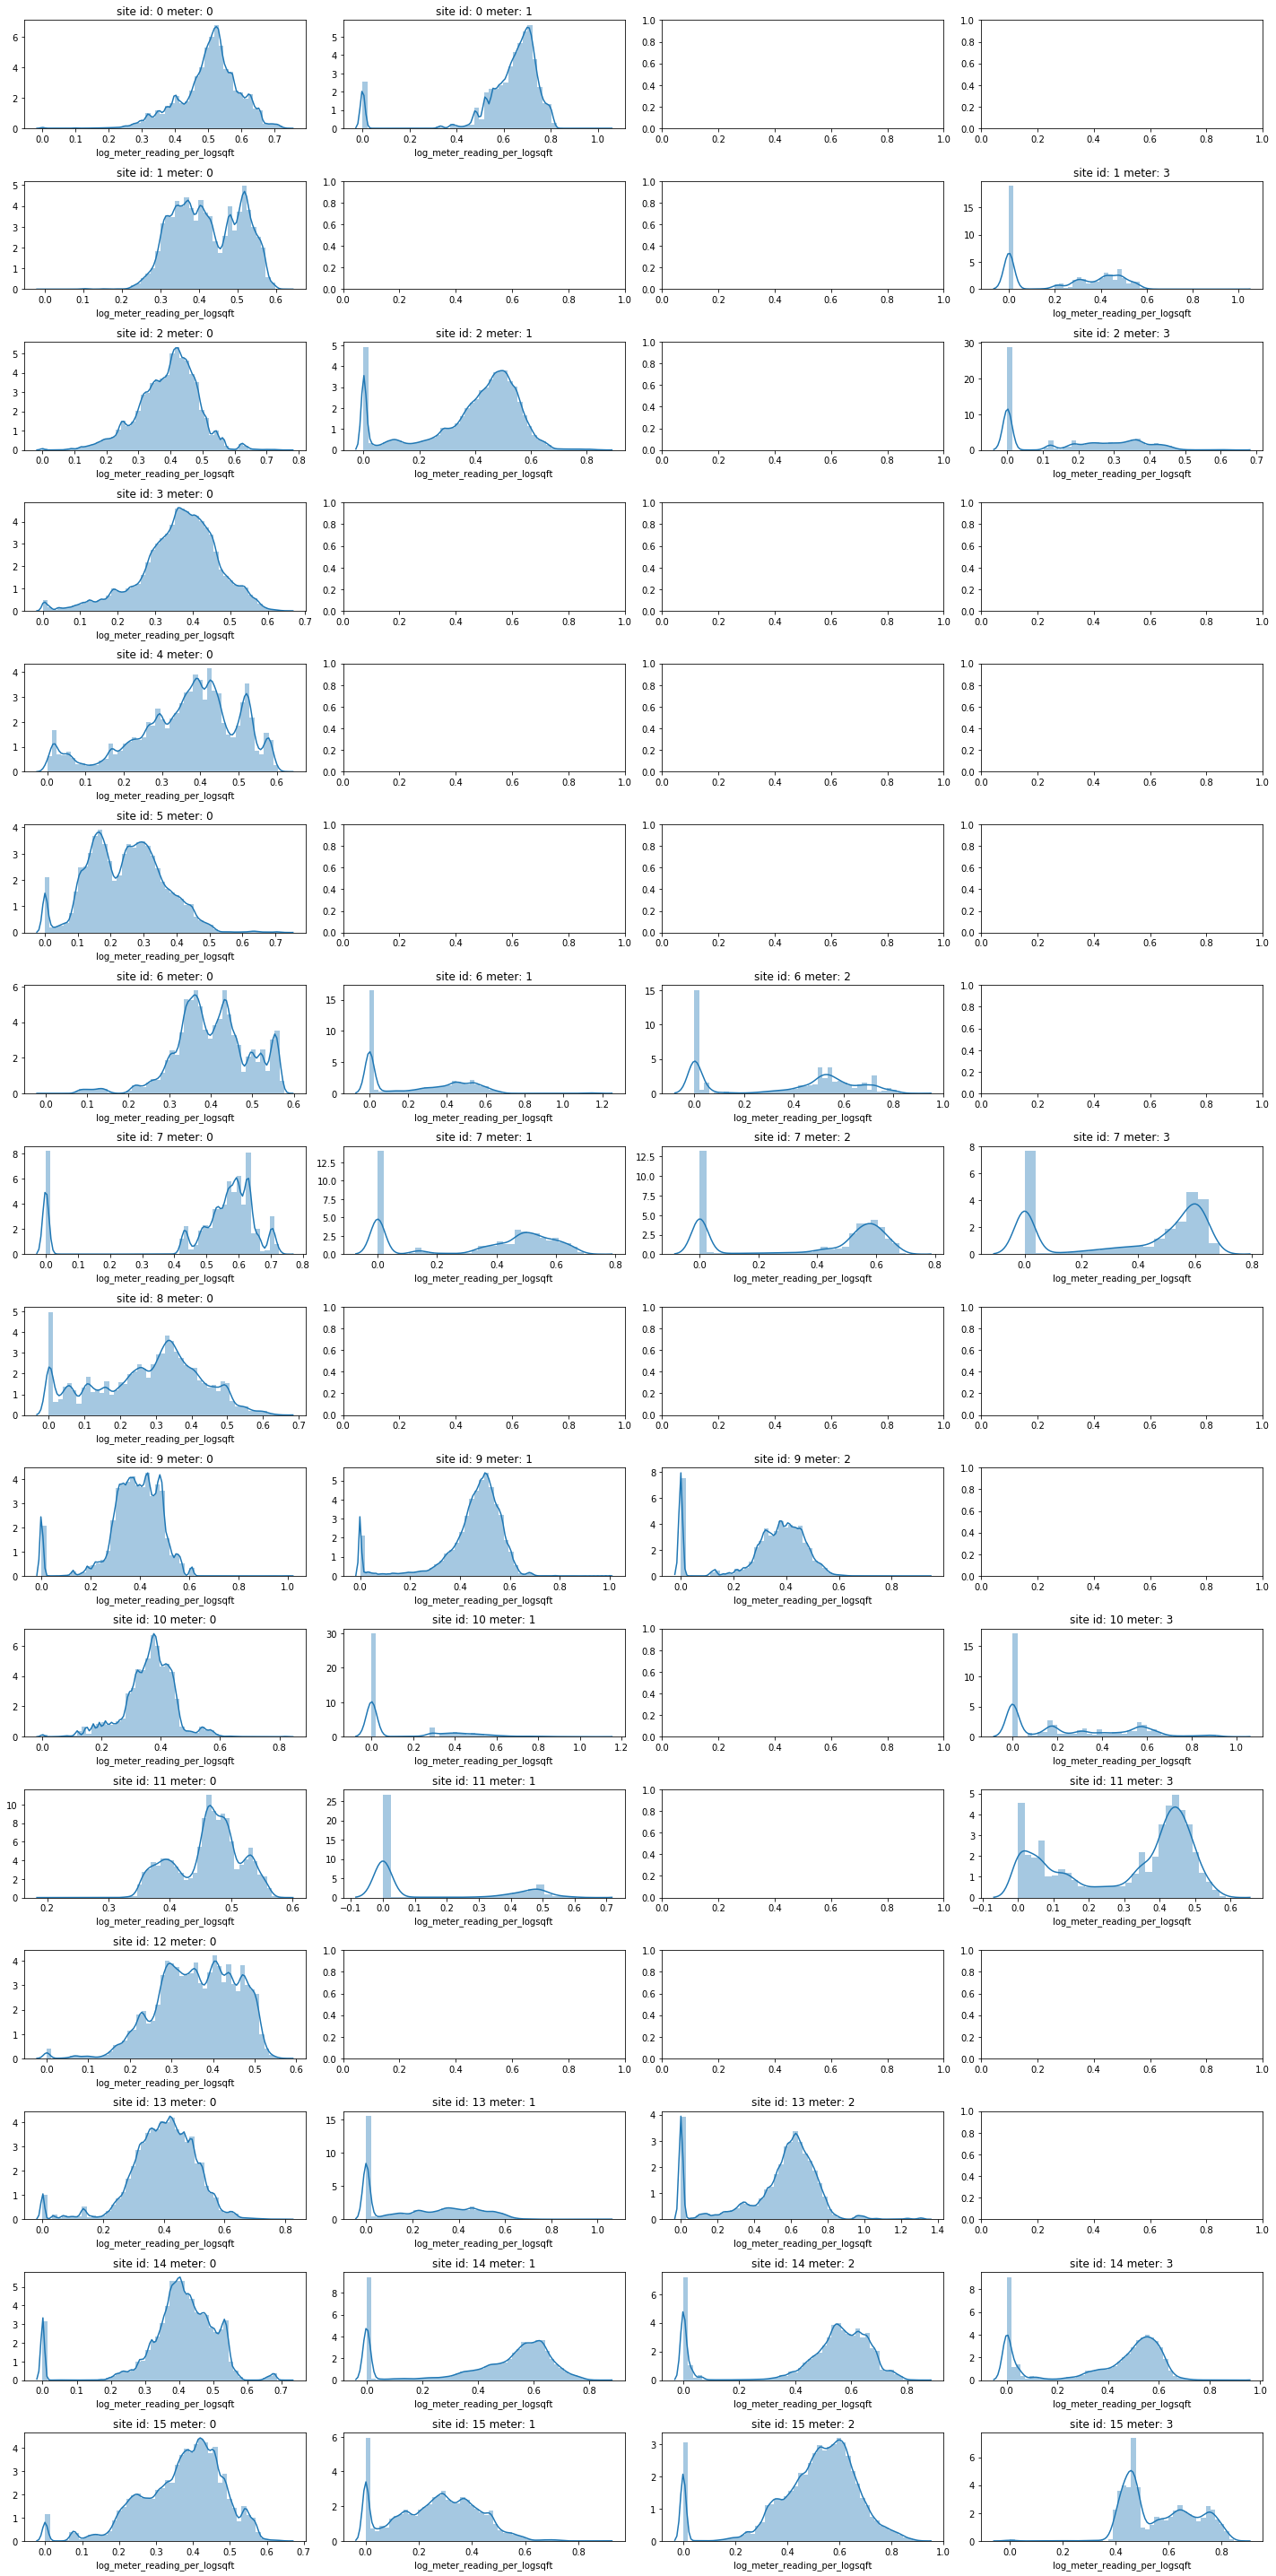

In [201]:
f, ax = plt.subplots(16, 4, figsize=(20,40))

i = 0
for site_id in list(range(0,16)):
    for meter in [0,1, 2, 3]:
        ax = f.axes[i]
        data = df_data[(df_data['site_id']==site_id) & (df_data.meter == meter)]
        if data.shape[0] !=0:
            sns.distplot(data['log_meter_reading_per_logsqft'], ax = ax)
            ax.set(title = 'site id: '+ str(site_id) + ' meter: '+ str(meter))
        i = i + 1
plt.tight_layout()

In [ ]:
##### Plot monthly usage at Site Id, building ID and meter

In [204]:
df_data_month_summary = pd.DataFrame()
df_data_month_summary = pd.crosstab([df_data.site_id, df_data.building_id, df_data.meter], df_data.month_year, df_data.log_meter_reading_per_logsqft, aggfunc=sum, margins = False )#, normalize = 'columns')
df_data_month_summary.reset_index(inplace = True)

In [203]:
### plot by excluding nan rows

from sklearn.preprocessing import normalize

df_buildings_with_nan = df_data_month_summary[df_data_month_summary.isnull().any(axis=1)]
df_data_month_summary_unitnorm = pd.DataFrame(columns = df_data_month_summary.columns)
df_data_month_summary_unitnorm[['site_id', 'building_id', 'meter']] = df_data_month_summary[df_data_month_summary.isnull().any(axis=1) == False][['site_id', 'building_id', 'meter']]
month_columns = ['01-2016', '02-2016', '03-2016', '04-2016', '05-2016', '06-2016', '07-2016', '08-2016', '09-2016', '10-2016', '11-2016', '12-2016']
df_data_month_summary_unitnorm[month_columns] = normalize(df_data_month_summary[df_data_month_summary.isnull().any(axis=1) == False][month_columns], norm = 'l2', axis = 1)


In [205]:
### plot by fillna with zero
from sklearn.preprocessing import normalize

df_data_month_summary.fillna(0, inplace = True)
df_data_month_summary_unitnorm = pd.DataFrame(columns = df_data_month_summary.columns)
df_data_month_summary_unitnorm[['site_id', 'building_id', 'meter']] = df_data_month_summary[['site_id', 'building_id', 'meter']]
month_columns = ['01-2016', '02-2016', '03-2016', '04-2016', '05-2016', '06-2016', '07-2016', '08-2016', '09-2016', '10-2016', '11-2016', '12-2016']
df_data_month_summary_unitnorm[month_columns] = normalize(df_data_month_summary[month_columns], norm = 'l2', axis = 1)



In [206]:
df_data_month_summary_unitnorm2 = pd.melt(df_data_month_summary_unitnorm, 
            id_vars=['site_id', 'building_id', 'meter'], 
            value_vars=list(df_data_month_summary_unitnorm.columns[3:]), # list of days of the week
            var_name='month', 
            value_name='sum_log_meter_reading_per_sqft')

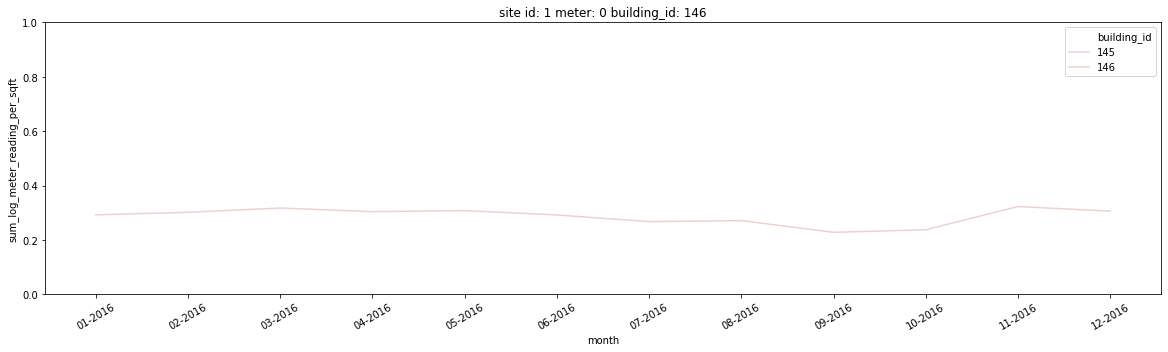

In [128]:
site_id = 1
meter = 0
building_id = 146
data = df_data_month_summary_unitnorm2[(df_data_month_summary_unitnorm2.site_id == site_id) & (df_data_month_summary_unitnorm2.meter == meter) & (df_data_month_summary_unitnorm2.building_id == building_id)]
f, ax = plt.subplots(1, 1, figsize=(20,5))
if data.shape[0] !=0:   
    sns.lineplot(x = 'month', y = 'sum_log_meter_reading_per_sqft', hue = 'building_id', data = data , ax = ax)
    ax.set(title = 'site id: '+ str(site_id) + ' meter: '+ str(meter) + ' building_id: ' + str(building_id), ylim = (0,1))
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)

In [136]:
df_data_month_summary_unitnorm2[df_data_month_summary_unitnorm2.site_id == 0].meter.unique()

array([0, 1])

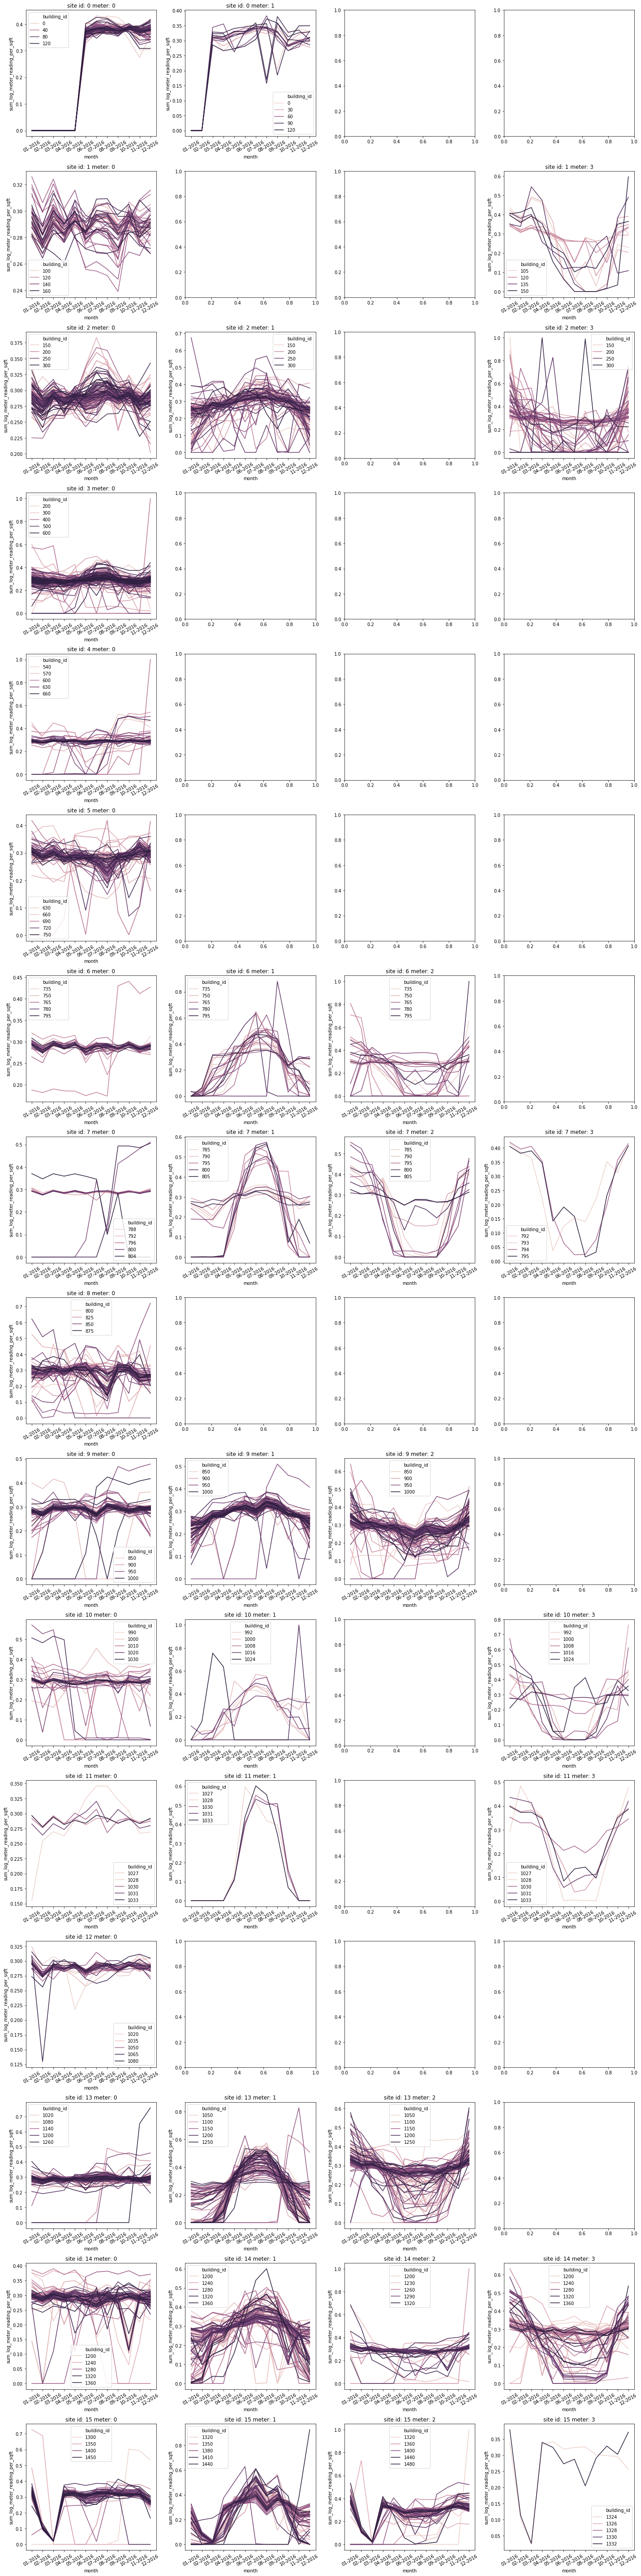

In [207]:
site_id = 4
meter = 4

i = 0
fig, ax = plt.subplots(16,4, figsize = (20, 80))
for site_id in list(range(0,16)):
    for meter in [0, 1, 2, 3]:
        ax = fig.axes[i]
        data = df_data_month_summary_unitnorm2[(df_data_month_summary_unitnorm2.site_id == site_id) & (df_data_month_summary_unitnorm2.meter == meter)]
        if data.shape[0] !=0:   
            sns.lineplot(x = 'month', y = 'sum_log_meter_reading_per_sqft', hue = 'building_id', data = data , ax = ax)
            ax.set(title = 'site id: '+ str(site_id) + ' meter: '+ str(meter))
            for tick in ax.get_xticklabels():
                tick.set_rotation(30)
        i = i + 1
plt.xticks(rotation= 30)
plt.tight_layout()

In [ ]:
##### Plot monthly usage at primary use, building ID and meter for a given site_id

In [208]:
df_data_month_summary_p_use = pd.DataFrame()
df_data_month_summary_p_use = pd.crosstab([df_data.site_id, df_data.primary_use, df_data.building_id, df_data.meter], df_data.month_year, df_data.log_meter_reading_per_logsqft, aggfunc=sum, margins = False )#, normalize = 'columns')
df_data_month_summary_p_use.reset_index(inplace = True)

In [209]:
### plot by fillna with zero
from sklearn.preprocessing import normalize

df_data_month_summary_p_use.fillna(0, inplace = True)
df_data_month_summary_unitnorm_p_use = pd.DataFrame(columns = df_data_month_summary_p_use.columns)
df_data_month_summary_unitnorm_p_use[['site_id','primary_use', 'building_id', 'meter']] = df_data_month_summary_p_use[['site_id', 'primary_use', 'building_id', 'meter']]
month_columns = ['01-2016', '02-2016', '03-2016', '04-2016', '05-2016', '06-2016', '07-2016', '08-2016', '09-2016', '10-2016', '11-2016', '12-2016']
df_data_month_summary_unitnorm_p_use[month_columns] = normalize(df_data_month_summary_p_use[month_columns], norm = 'l2', axis = 1)



In [157]:
df_data_month_summary_unitnorm_p_use.to_excel('normalized_monthly_usage2.xlsx')

In [210]:
df_data_month_summary_unitnorm2_p_use = pd.melt(df_data_month_summary_unitnorm_p_use, 
            id_vars=['site_id','primary_use','building_id', 'meter'], 
            value_vars=list(df_data_month_summary_unitnorm_p_use.columns[4:]), # list of days of the week
            var_name='month', 
            value_name='sum_log_meter_reading_per_sqft')

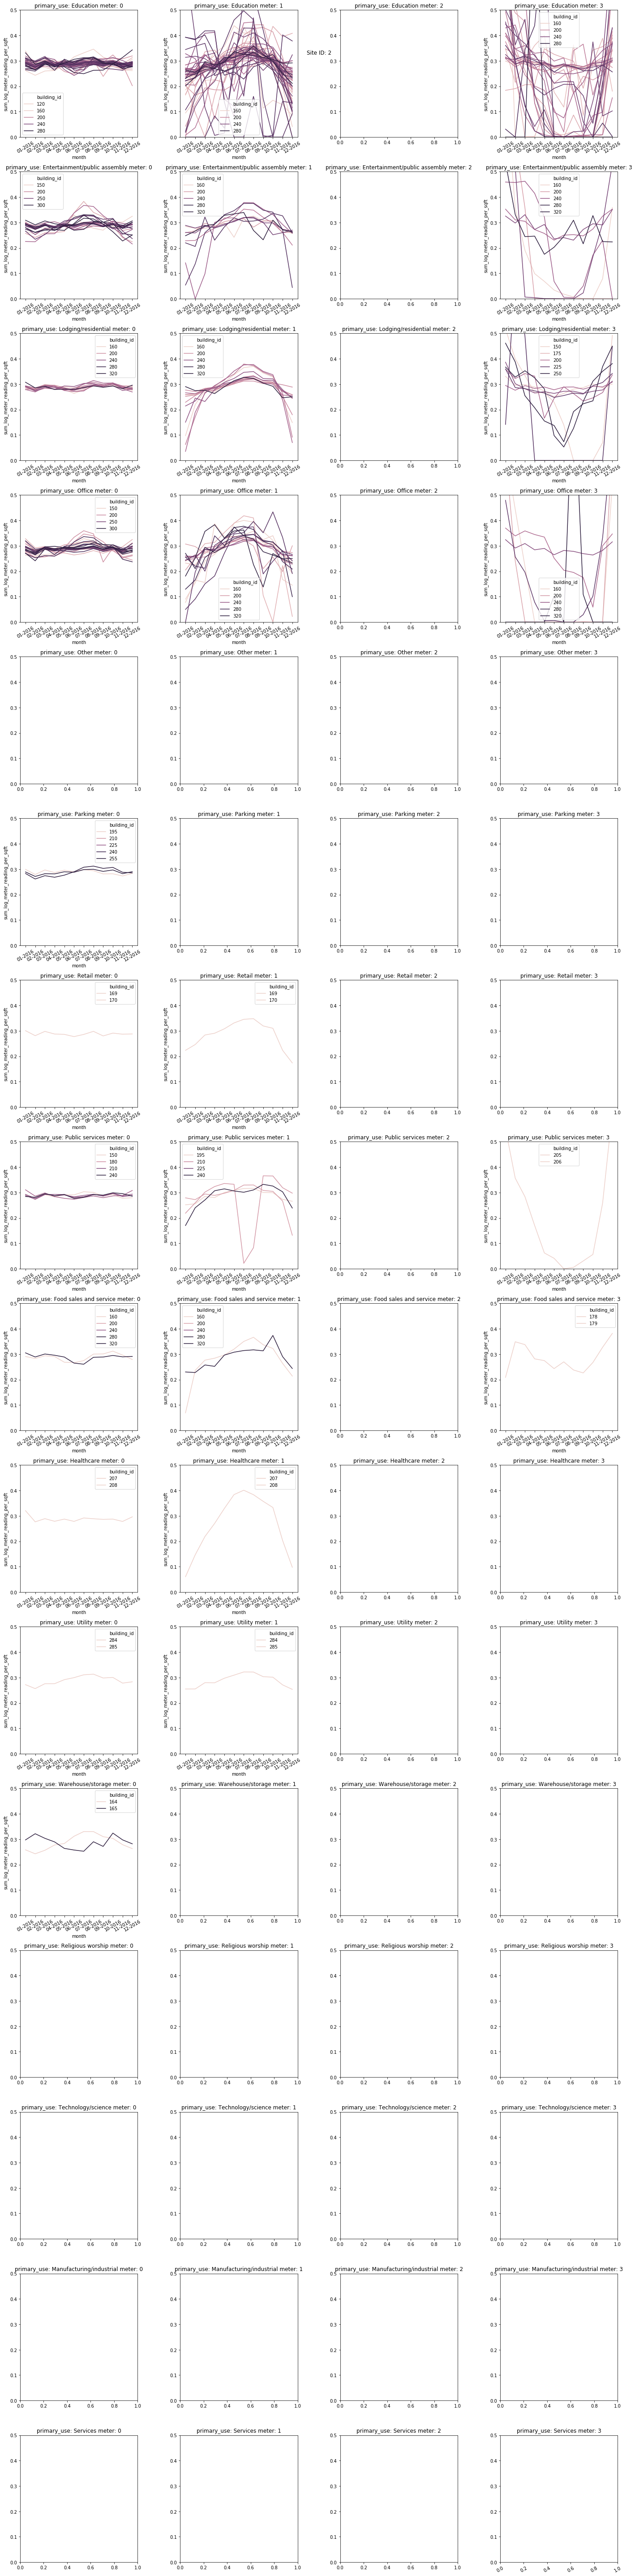

In [212]:
site_id = 2

i = 0
fig, ax = plt.subplots(16,4, figsize = (20, 80))
for primary_use in df_data_month_summary_unitnorm2_p_use.primary_use.unique():
    for meter in [0, 1, 2, 3]:
        ax = fig.axes[i]
        data = df_data_month_summary_unitnorm2_p_use[(df_data_month_summary_unitnorm2_p_use.site_id == site_id) & (df_data_month_summary_unitnorm2_p_use.primary_use == primary_use) & (df_data_month_summary_unitnorm2_p_use.meter == meter)]
        ax.set(title = 'primary_use: '+ str(primary_use) + ' meter: '+ str(meter), ylim = (0, 0.5))
        if data.shape[0] !=0:   
            sns.lineplot(x = 'month', y = 'sum_log_meter_reading_per_sqft', hue = 'building_id', data = data , ax = ax)
            for tick in ax.get_xticklabels():
                tick.set_rotation(30)
        i = i + 1
fig.suptitle('Site ID: ' + str(site_id))
plt.xticks(rotation= 30)
plt.tight_layout()

In [ ]:
##### Plot daily usage at primary use, building ID and meter for a given site_id

In [34]:
df_data['sq_log_meter_reading_per_logsqft'] = df_data.log_meter_reading_per_logsqft**2

In [41]:
df_cumsum_sq_log_meter_reading_per_logsqft = pd.DataFrame()
df_cumsum_sq_log_meter_reading_per_logsqft['cumsum_sq_log_meter_reading_per_logsqft'] = df_data.groupby(['site_id','primary_use', 'building_id', 'meter'])['sq_log_meter_reading_per_logsqft'].sum()
df_cumsum_sq_log_meter_reading_per_logsqft.reset_index(inplace = True)

In [45]:
df_data2 = pd.merge(df_data, df_cumsum_sq_log_meter_reading_per_logsqft, on=['site_id','primary_use', 'building_id', 'meter'], how = 'left')

In [52]:
df_data2['denominator_for_l2norm'] = df_data2.cumsum_sq_log_meter_reading_per_logsqft.apply(lambda x: np.sqrt(x))
df_data2['normalized_log_meter_reading_per_logsqft'] = df_data2.log_meter_reading_per_logsqft / df_data2.denominator_for_l2norm

In [ ]:
site_id = 0
meter = 0
i = 0
fig, ax = plt.subplots(16,1, figsize = (20, 80))
for primary_use in df_data2.primary_use.unique():
    ax = fig.axes[i]
    data = df_data2[(df_data2.site_id == site_id) & (df_data2.primary_use == primary_use) & (df_data2.meter == meter)]
    ax.set(title = 'primary_use: '+ str(primary_use) + ' meter: '+ str(meter))
    if data.shape[0] !=0:   
        sns.lineplot(x = 'day_hour', y = 'normalized_log_meter_reading_per_logsqft', hue = 'building_id', data = data , ax = ax)
        for tick in ax.get_xticklabels():
            tick.set_rotation(30)
    i = i + 1
fig.suptitle('Site ID: ' + str(site_id))
plt.xticks(rotation= 30)
plt.tight_layout()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


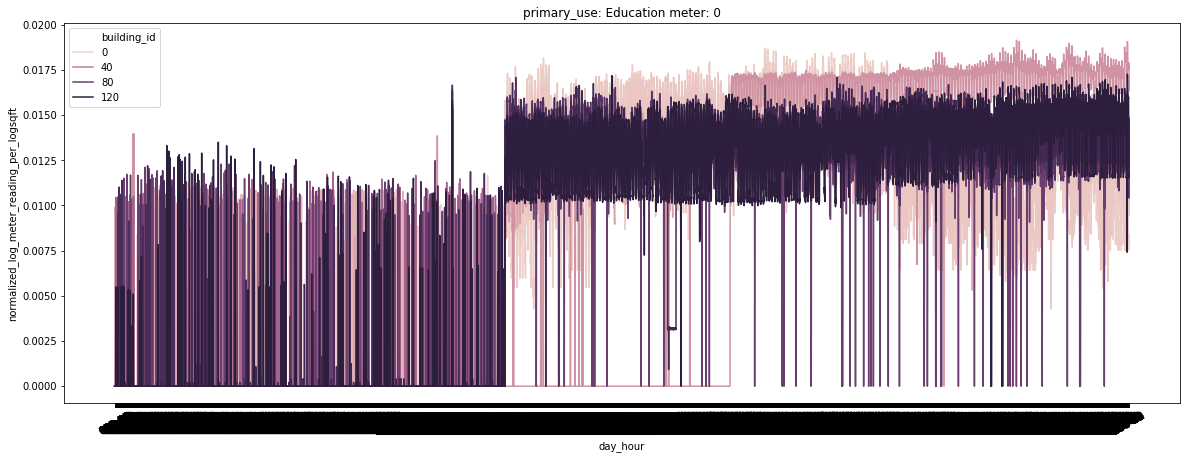

In [66]:
site_id = 0
meter = 0
primary_use = 'Education'
fig, ax = plt.subplots(1,1, figsize = (20, 7))
data = df_data2[(df_data2.site_id == site_id) & (df_data2.primary_use == primary_use) & (df_data2.meter == meter)]
ax.set(title = 'primary_use: '+ str(primary_use) + ' meter: '+ str(meter))
if data.shape[0] !=0:   
    sns.scatterplot(x = 'day_hour', y = 'normalized_log_meter_reading_per_logsqft', hue = 'building_id', data = data , ax = ax)
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)

In [78]:
temp = df_data2[(df_data2.building_id == 7) & (df_data2.meter == 1) ]

In [79]:
temp

building_id  meter           timestamp  meter_reading  site_id  \
3172286             7      1 2016-02-29 09:00:00     1857.26000        0   
3174385             7      1 2016-02-29 10:00:00     2659.25000        0   
3176488             7      1 2016-02-29 11:00:00     2912.51000        0   
3178590             7      1 2016-02-29 12:00:00     3039.15000        0   
3180681             7      1 2016-02-29 13:00:00     3207.99000        0   
...               ...    ...                 ...            ...      ...   
20204282            7      1 2016-12-31 19:00:00     1688.41000        0   
20206645            7      1 2016-12-31 20:00:00     1477.36000        0   
20209011            7      1 2016-12-31 21:00:00     1308.52000        0   
20211376            7      1 2016-12-31 22:00:00     1013.05000        0   
20213742            7      1 2016-12-31 23:00:00      633.15500        0   

         primary_use  square_feet  year_built  floor_count  \
3172286    Education       121074  1989.00000          nan   
3174385    Education       121074  1989.00000          nan   
3176488    Education       121074  1989.00000          nan   
3178590    Education       121074  1989.00000          nan   
3180681    Education       121074  1989.00000          nan   
...              ...          ...         ...          ...   
20204282   Education       121074  1989.00000          nan   
20206645   Education       121074  1989.00000          nan   
20209011   Education       121074  1989.00000          nan   
20211376   Education       121074  1989.00000          nan   
20213742   Education       121074  1989.00000          nan   

          meter_reading_per_sqft_log1p  log_meter_reading_per_logsqft  \
3172286                        0.01522                        0.64314   
3174385                        0.02173                        0.67379   
3176488                        0.02377                        0.68156   
3178590                        0.02479                        0.68520   
3180681                        0.02615                        0.68982   
...                                ...                            ...   
20204282                       0.01385                        0.63500   
20206645                       0.01213                        0.62360   
20209011                       0.01075                        0.61324   
20211376                       0.00833                        0.59139   
20213742                       0.00522                        0.55128   

          day_of_the_year day_hour month_year  hour_of_the_day  \
3172286                60   060-09    02-2016                9   
3174385                60   060-10    02-2016               10   
3176488                60   060-11    02-2016               11   
3178590                60   060-12    02-2016               12   
3180681                60   060-13    02-2016               13   
...                   ...      ...        ...              ...   
20204282              366   366-19    12-2016               19   
20206645              366   366-20    12-2016               20   
20209011              366   366-21    12-2016               21   
20211376              366   366-22    12-2016               22   
20213742              366   366-23    12-2016               23   

          air_temperature  cloud_coverage  dew_temperature  precip_depth_1_hr  \
3172286          12.80000             nan          8.90000            0.00000   
3174385          12.20000             nan          9.40000            0.00000   
3176488          12.80000             nan          9.40000            0.00000   
3178590          11.10000         6.00000          8.90000            0.00000   
3180681          13.30000             nan         11.10000            0.00000   
...                   ...             ...              ...                ...   
20204282         22.80000             nan         10.00000            0.00000   
20206645         23.30000         

In [150]:
#temp = df_data[(df_data.building_id.isin([29, 45, 46, 53, 59, 83])) & (df_data.meter == 0) & (df_data.site_id ==0)]
temp = df_data[(df_data.meter == 3) & (df_data.site_id ==1)]
temp.to_excel('siteid 1 meter 3.xlsx')

In [77]:
temp = pd.DataFrame()
temp['total'] = df_data.groupby(['site_id', 'primary_use', 'building_id', 'meter'])['timestamp'].count()
temp[['min_meter_reading', 'non_zero_count']] = df_data[df_data.meter_reading != 0].groupby(['site_id', 'primary_use', 'building_id', 'meter']).agg({'meter_reading':'min','timestamp': 'count'})
temp['zero_count'] = df_data[df_data.meter_reading == 0].groupby(['site_id', 'primary_use', 'building_id', 'meter'])['building_id'].count()
temp.zero_count.fillna(0, inplace = True)
temp.non_zero_count.fillna(0, inplace = True)
temp.to_excel('zero_row_count.xlsx')

In [106]:
df_data[(df_data.building_id == 106) & (df_data.meter == 0) & (df_data['timestamp'] >= '2016-05-13') & (df_data['timestamp'] <= '2016-10-31')].head(20)

building_id  meter           timestamp  meter_reading  site_id  \
7140778          112      0 2016-05-13 00:00:00       14.75540        1   
7143124          112      0 2016-05-13 01:00:00       29.62870        1   
7145470          112      0 2016-05-13 02:00:00       29.37870        1   
7147816          112      0 2016-05-13 03:00:00       28.44170        1   
7150161          112      0 2016-05-13 04:00:00       28.12870        1   
7152506          112      0 2016-05-13 05:00:00       27.50370        1   
7154852          112      0 2016-05-13 06:00:00       30.87870        1   
7157199          112      0 2016-05-13 07:00:00       32.44070        1   
7159545          112      0 2016-05-13 08:00:00       30.44170        1   
7161892          112      0 2016-05-13 09:00:00       34.50370        1   
7164236          112      0 2016-05-13 10:00:00       37.50370        1   
7166583          112      0 2016-05-13 11:00:00       40.44070        1   
7168932          112      0 2016-05-13 12:00:00       10.75540        1   
7171278          112      0 2016-05-13 13:00:00        0.00700        1   
7173625          112      0 2016-05-13 14:00:00        0.00700        1   
7175969          112      0 2016-05-13 15:00:00        0.00700        1   
7178317          112      0 2016-05-13 16:00:00        0.00700        1   
7180665          112      0 2016-05-13 17:00:00        0.00700        1   
7183011          112      0 2016-05-13 18:00:00        0.00700        1   
7185358          112      0 2016-05-13 19:00:00        0.00700        1   

        primary_use  square_feet  year_built  floor_count  \
7140778   Education        32206         nan      6.00000   
7143124   Education        32206         nan      6.00000   
7145470   Education        32206         nan      6.00000   
7147816   Education        32206         nan      6.00000   
7150161   Education        32206         nan      6.00000   
7152506   Education        32206         nan      6.00000   
7154852   Education        32206         nan      6.00000   
7157199   Education        32206         nan      6.00000   
7159545   Education        32206         nan      6.00000   
7161892   Education        32206         nan      6.00000   
7164236   Education        32206         nan      6.00000   
7166583   Education        32206         nan      6.00000   
7168932   Education        32206         nan      6.00000   
7171278   Education        32206         nan      6.00000   
7173625   Education        32206         nan      6.00000   
7175969   Education        32206         nan      6.00000   
7178317   Education        32206         nan      6.00000   
7180665   Education        32206         nan      6.00000   
7183011   Education        32206         nan      6.00000   
7185358   Education        32206         nan      6.00000   

         meter_reading_per_sqft_log1p  log_meter_reading_per_logsqft day_hour  \
7140778                       0.00046                        0.26563   134-00   
7143124                       0.00092                        0.32967   134-01   
7145470                       0.00091                        0.32888   134-02   
7147816                       0.00088                        0.32586   134-03   
7150161                       0.00087                        0.32483   134-04   
7152506                       0.00085                        0.32274   134-05   
7154852                       0.00096                        0.33352   134-06   
7157199                       0.00101                        0.33813   134-07   
7159545                       0.00094                        0.33219   134-08   
7161892                       0.00107                        0.34390   134-09   
7164236                       0.00116                        0.35171   134-10   
7166583                       0.00125                        0.35879   134-11   
7168932                       0.00033                        0.23741   134-12   
7171278          